 ## Before starting to create classification models, we had to do some pre-work.
 ### First, we imported every library that we might've used.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import math
#regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from IPython.display import display, Markdown, Latex
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import feature_selection

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn import svm
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# style of the plots
plt.style.use('seaborn-pastel')
# seed for repetability of results
_SEED = 2567

### We then read the csv file

In [45]:
berlin = pd.read_csv("listings_berlin.csv")
berlin3 = pd.read_csv("listings_detailed.csv")

#### Adding extra features from detailed csv file.

In [46]:
berlin3.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [47]:
extra = berlin3[['bedrooms', 'beds', 'accommodates', 'maximum_nights']]

In [48]:
extra

,bedrooms,beds,accommodates,maximum_nights
0,2.0,3.0,5,1125
1,1.0,2.0,2,100
2,1.0,1.0,2,120
3,2.0,2.0,6,365
4,1.0,2.0,4,1125
...,...,...,...,...
16675,1.0,3.0,3,1125
16676,2.0,2.0,4,1125
16677,1.0,4.0,6,1125
16678,1.0,1.0,2,365


In [49]:
berlin = berlin.join(extra)

In [50]:
berlin['bedrooms'] = berlin['bedrooms'].fillna(0).astype(int)
berlin['beds'] = berlin['beds'].fillna(0).astype(int)

### Next, we removed unnecessary and problematic columns, replaced NaN values with average value for that column.

In [51]:
to_remove = ['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
             'longitude', 'last_review', 'calculated_host_listings_count']
berlin2 = berlin.drop(columns = to_remove)

berlin2 = berlin2.fillna(berlin2.mean())
print(berlin2.columns.values.tolist())

['neighbourhood_group', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'number_of_reviews_ltm', 'license', 'bedrooms', 'beds', 'accommodates', 'maximum_nights']


C:\Users\Alper\AppData\Local\Temp\ipykernel_13152\2335399480.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  berlin2 = berlin2.fillna(berlin2.mean())


In [52]:
berlin2.isnull().sum()

neighbourhood_group          0
room_type                    0
price                        0
minimum_nights               0
number_of_reviews            0
reviews_per_month            0
availability_365             0
number_of_reviews_ltm        0
license                  11048
bedrooms                     0
beds                         0
accommodates                 0
maximum_nights               0
dtype: int64

### Dropped another column ***license***.

In [53]:
berlin2.drop('license', axis=1, inplace=True)

In [54]:
berlin2.isnull().sum()

neighbourhood_group      0
room_type                0
price                    0
minimum_nights           0
number_of_reviews        0
reviews_per_month        0
availability_365         0
number_of_reviews_ltm    0
bedrooms                 0
beds                     0
accommodates             0
maximum_nights           0
dtype: int64

### Removed rows containing price == 0 and put together all room types for more balance in dataset.

In [55]:
berlin2 = berlin2[(berlin2['price'] != 0)]

berlin2['room_type'] = berlin2['room_type'].replace('Shared room', 'Private room')
berlin2['room_type'] = berlin2['room_type'].replace('Hotel room', 'Private room')
print(berlin2['room_type'].value_counts())

Entire home/apt    9904
Private room       6772
Name: room_type, dtype: int64


### We used pandas.factorize() to encode the array values.

In [56]:
berlin2['neighbourhood_group'] = pd.Categorical(pd.factorize(berlin2['neighbourhood_group'])[0])
berlin2['room_type'] = pd.Categorical(pd.factorize(berlin2['room_type'])[0])

print('+Types:\n\n'+ str(berlin2.dtypes))
berlin2.head()

+Types:

neighbourhood_group      category
room_type                category
price                       int64
minimum_nights              int64
number_of_reviews           int64
reviews_per_month         float64
availability_365            int64
number_of_reviews_ltm       int64
bedrooms                    int32
beds                        int32
accommodates                int64
maximum_nights              int64
dtype: object


,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,bedrooms,beds,accommodates,maximum_nights
0,0,0,88,1,0,0.860941,6,0,2,3,5,1125
1,1,0,60,2,126,2.540000,163,18,1,2,2,100
2,2,0,36,8,29,0.630000,6,6,1,1,2,120
3,2,0,120,1,0,0.860941,257,0,2,2,6,365
4,2,0,110,5,1,0.030000,160,0,1,2,4,1125


In [57]:
display(Markdown('The final shape of the cleaned dataset is: '+ str(berlin2.shape)))

The final shape of the cleaned dataset is: (16676, 12)

### Next, we made some preparations for classification, removed categorical data, standardize the data.

In [58]:
# Preparing for regression
y_regr = berlin2['price']
x_regr = berlin2.drop(columns='price')

# Preparing for classification
y_class = berlin2['room_type']
x_class = berlin2.drop(columns='room_type')

# We removed the categorical data before the data standardize
rooms_t = berlin2['room_type']  
districts = berlin2['neighbourhood_group']
x_regr = x_regr.drop(columns='room_type')
x_regr = x_regr.drop(columns='neighbourhood_group')
x_class = x_class.drop(columns='neighbourhood_group')

# We standardized the data
x_regr = (x_regr - x_regr.mean()) / x_regr.std()
# Instead of StandardScaler().fit_transform, we did it manually.
# Because StandardScaler() function did not work well, for a reason we are not sure of.

x_class = (x_class - x_class.mean()) / x_class.std()
# Instead of StandardScaler().fit_transform, we did it manually.
# Because StandardScaler() function did not work well, for a reason we are not sure of.


# We tried to avoid too little values (almost near to 0 values)
x_regr[abs(x_regr) < 1e-12] = 0
x_class[abs(x_class) < 1e-12] = 0

# We also tried to avoid infinite values if there's any.
x_regr.replace(np.inf, np.finfo(np.float64).max)
x_class.replace(-np.inf, -np.finfo(np.float64).max)

# We added the categorical columns
x_regr['room_type'] = rooms_t
x_regr['neighbourhood_group'] = districts
x_class['neighbourhood_group'] = districts

#### Following we saw how the columns got shaped after the standardization (except the categorical ones)
#### and they have 0 mean and standard deviation equal to 1.

In [59]:
x_class.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,bedrooms,beds,accommodates,maximum_nights
count,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04,1.667600e+04
mean,-1.730366e-15,1.013368e-15,1.508614e-17,-1.639344e-14,1.051747e-14,-2.579617e-15,-8.336992e-16,8.535955e-16,5.516283e-15,1.345321e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.563247e-01,-2.841701e-01,-4.457681e-01,-5.625180e-01,-7.020064e-01,-3.375021e-01,-1.645154e+00,-1.277378e+00,-1.640645e+00,-1.074414e+00
25%,-4.823287e-01,-2.586112e-01,-4.297186e-01,-4.964163e-01,-7.020064e-01,-3.375021e-01,-2.553572e-01,-5.281412e-01,-4.584816e-01,-1.019486e+00
50%,-2.682694e-01,-2.330523e-01,-3.494707e-01,-2.452298e-01,-7.020064e-01,-3.375021e-01,-2.553572e-01,-5.281412e-01,-4.584816e-01,-3.849739e-01
75%,1.170374e-01,-1.819346e-01,-9.267768e-02,-3.135198e-05,6.545772e-01,-3.344846e-02,-2.553572e-01,2.210960e-01,7.236814e-01,1.054517e+00
max,3.663556e+01,2.841845e+01,2.335574e+01,5.323105e+01,2.262982e+00,4.836176e+01,1.503241e+01,1.520584e+01,7.816659e+00,1.786246e+01


#### In order to reduce the size of the column list,
#### we performed a binary encoding on the neighbourhood columns.

In [60]:
dummy_regr = x_regr.drop(columns=['neighbourhood_group'])
dummy_regr = dummy_regr.reset_index(drop = True)

dummy_class = x_class.drop(columns=['neighbourhood_group'])
dummy_class = dummy_class.reset_index(drop = True)

b_vec = []
b_vec.append([0, 0, 0, 0])
b_vec.append([0, 0, 0, 1])
b_vec.append([0, 0, 1, 0])
b_vec.append([0, 0, 1, 1])
b_vec.append([0, 1, 0, 0])
b_vec.append([0, 1, 0, 1])
b_vec.append([0, 1, 1, 0])
b_vec.append([0, 1, 1, 1])
b_vec.append([1, 0, 0, 0])
b_vec.append([1, 0, 0, 1])
b_vec.append([1, 0, 1, 0])
b_vec.append([1, 0, 1, 1])


bin_neighs = []
val = []

for idx, neighs_val in enumerate(x_regr['neighbourhood_group']):
    val.append(neighs_val)
    bin_neighs.append(b_vec[neighs_val])

dummy_regr[['N_ENC1', 'N_ENC2', 'N_ENC3', 'N_ENC4']] = pd.DataFrame(bin_neighs)
dummy_regr = dummy_regr.astype({'N_ENC1': int,  'N_ENC2': int, 'N_ENC3': int, 'N_ENC4': int})

dummy_class[['N_ENC1', 'N_ENC2', 'N_ENC3', 'N_ENC4']] = pd.DataFrame(bin_neighs)
dummy_class = dummy_class.astype({'N_ENC1': int,  'N_ENC2': int, 'N_ENC3': int, 'N_ENC4': int})

#### classification dataset are shown here below.

In [61]:
dummy_class.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,bedrooms,beds,accommodates,maximum_nights,N_ENC1,N_ENC2,N_ENC3,N_ENC4
0,-0.071335,-0.284170,-0.445768,-0.000031,-0.653267,-0.337502,1.134440,0.970333,1.314763,1.054517,0,0,0,0
1,-0.311081,-0.258611,1.576477,1.109855,0.622084,0.574659,-0.255357,0.221096,-0.458482,-0.886901,0,0,0,1
2,-0.516578,-0.105258,0.019669,-0.152687,-0.653267,-0.033448,-0.255357,-0.528141,-0.458482,-0.849020,0,0,1,0
3,0.202661,-0.284170,-0.445768,-0.000031,1.385670,-0.337502,1.134440,0.221096,1.905844,-0.384974,0,0,1,0
4,0.117037,-0.181935,-0.429719,-0.549298,0.597714,-0.337502,-0.255357,0.221096,0.723681,1.054517,0,0,1,0


## Principal component analysis (PCA) :
#### is an unsupervised technique used for dimensionality reduction for pre-processing before supervised methods.

Text(0.5, 1.0, 'Classification data')

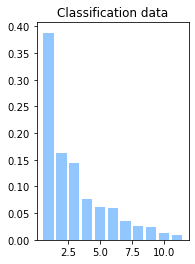

In [62]:
### Proportion of Variance Explained (PVE) FOR CLASSIFICATION DATA:

pca_class = PCA()
x_class_pca = pca_class.fit_transform(x_class)

cvar_arr = pca_class.explained_variance_ratio_
plt.subplot(1, 2, 1)
plt.bar(np.arange(1, len(cvar_arr)+1), cvar_arr)
plt.title('Classification data')

### The first 3 components of dataset explain about the 80% of the total variance so we used 3 PCs for the PCA. 
### Here below we have reported the three scatter-plot for the regression dataset.

In [92]:
## PCA FOR CLASSIFICATION DATA:

pca_class = PCA(n_components=3)
x_class_pca = pca_class.fit_transform(x_class)

In [96]:
# Next, we turned it back into dataframe
x_class_pca = pd.DataFrame(x_class_pca, columns=['PC1', 'PC2', 'PC3'])

#### Next, we defined a dictionary that would contain all the accuracies produced by the classifiers we used,
#### defined the functions used to plot the learning curve.

In [94]:
accuracies= {}

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(12,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel('#samples')
    plt.ylabel('Score')
    plt.title(title)
    plt.show()

## SUPPORT VECTOR MACHINE (SVM):
#### The goal of the support vector classifier (SVC) is to find the hyperplane that separates the classes in feature space.

In [67]:
def our_SVM_func(dataset, y_class, kernel):
    
    x_train, x_test, y_train, y_test = train_test_split(dataset, y_class, test_size=0.3, random_state= None)
    x_train_complete = x_train
    y_train_complete = y_train
    # slit in validation and train sets, for further evaluation
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state= None)
    print("SVM with %s kernel" % kernel)
    print("Size dataset: %d" % len(dummy_class))
    print("Size train set: %d" % len(x_train))
    print("Size validation set: %d" % len(x_val))
    print("Size test set: %d" % len(x_test))
  
  
    # Train and test, with validation set, for evaluating the C parameter from 10^-3 to 10^3
    c_min = 10**-3
    c_max = 10**3

    accuracies = []
    accuracy_max = 0  
    print("\nEvaluate SVM performace changing the C parameter")
    c = c_min
    while c <= c_max:
        print("\nTraining with C= %.3f" % c)
        classifier = svm.SVC(C = c, kernel = kernel, gamma= 'auto')
        classifier.fit(x_train, y_train) # train on train set
        print("\t|->End training\nTesting with validation set:")
        y_pred_val = classifier.predict(x_val) # evaluate on validation set
        accuracy = 100*f1_score(y_val, y_pred_val, average='binary')
        print("\t|->End testing - Accuracy= %.2f%%" % accuracy)
        accuracies.append(accuracy)
        if accuracy > accuracy_max:
            accuracy_max = accuracy
            best_c = c
        c *= 10

    for i in range(len(accuracies)):
        print("Accuracy %d : %.2f%%" % (i+1, accuracies[i]))
    print("Best C parameter is: %f with accuracy: %.2f%%" % (best_c, accuracy_max))

    # Here we tested the model with the test set and the best C found
    print("\nTraining with C= %.3f" % best_c)
    classifier = svm.SVC(C = best_c, kernel = kernel, gamma= 'auto')
    classifier.fit(x_train, y_train) # train on train set
    print("\t|->End training\nTesting with test set:")
    y_pred = classifier.predict(x_test) # evaluate on test set
    accuracy = 100*f1_score(y_test, y_pred, average='binary')
    print("\t|->End testing - Accuracy= %.2f%%" % accuracy) 
  
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report")
    print(classification_report(y_test, y_pred))
 
    return accuracy
  
def our_SVM_func_with_GridSearch(dataset, y_class, kernel):
    # Grid Search with 5-fold validation
    x_train, x_test, y_train, y_test = train_test_split(dataset, y_class, test_size=0.3, random_state= None)
  
    svc = svm.SVC(kernel= kernel)
    parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'gamma':[10**-11, 10**-9, 10**-7, 10**-5, 10**-3, 10**-1, 10]}
    classifier= GridSearchCV(svc, parameters, cv= 5)
    print("SVM with %s kernel and GridSearch\nTraining..." % kernel)
    classifier.fit(x_train, y_train)
    print("End training, test:")
    y_pred = classifier.predict(x_test)
    best_c= classifier.best_params_['C']
    best_gamma= classifier.best_params_['gamma']
    best_accuracy= 100*classifier.best_score_
    print('Best parameters found in the Grid Search with 5-fold validation: ' + str(classifier.best_params_))
    print('Accuracy with these best parameters: %.2f' % best_accuracy + '%')

    # Evaluate score on the test set, with the best C and gamma values found
    accuracy = 100*f1_score(y_test, y_pred, average='binary')
    print('Accuracy on the test set with best parameters found %.2f%%' % accuracy)
  
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report")
    print(classification_report(y_test, y_pred))
    classifier = svm.SVC(C = best_c, kernel = kernel, gamma=best_gamma)
    title = "Learning curve for SVM with " + kernel + " kernel and hyperparameters estimated with grid search"
    plot_learning_curve(classifier, title, x_train, y_train, cv=5)
    return accuracy

#### SVM with dataset composed by dummy variables:

SVM with linear kernel
Size dataset: 16676
Size train set: 9338
Size validation set: 2335
Size test set: 5003

Evaluate SVM performace changing the C parameter

Training with C= 0.001
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 0.00%

Training with C= 0.010
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 68.76%

Training with C= 0.100
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 70.54%

Training with C= 1.000
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 71.04%

Training with C= 10.000
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 70.94%

Training with C= 100.000
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 71.04%

Training with C= 1000.000
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 71.07%
Accuracy 1 : 0.00%
Accuracy 2 : 68.76%
Accuracy 3 : 70.54%
Accuracy 4 : 71.04%
Accuracy 5 : 70.94%
A

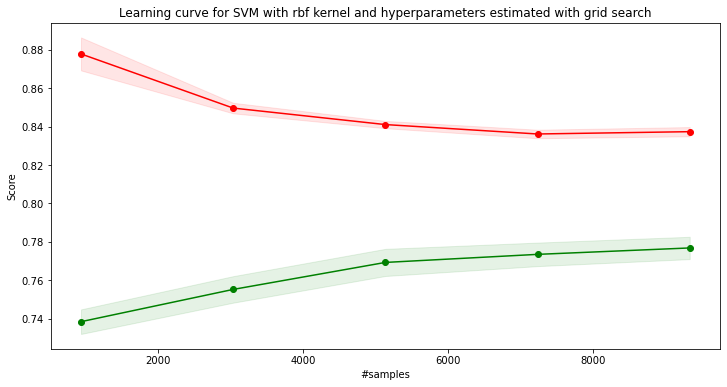

In [68]:
# Perform the svm, with linear kernel
accuracies["SVM_linear"] = our_SVM_func(dummy_class, y_class, 'linear')

# Perform the svm, with rbf kernel
accuracies["SVM_rbf"] = our_SVM_func_with_GridSearch(dummy_class, y_class, 'rbf')

## DECISION TREE :

In [69]:
# We defined out decision tree function here.

def our_dec_tree_func(dataset, y_class, max_depth):
    x_train, x_test, y_train, y_test = train_test_split(dataset, y_class, test_size=0.3, random_state= None)
    print("\nTraining with maximum depth= %d" % max_depth)
    classifier = DecisionTreeClassifier(criterion="entropy", max_depth= max_depth)
    classifier.fit(x_train, y_train) # train on train set
    print("\t|->End training\nTesting with test set:")
    y_pred = classifier.predict(x_test) # evaluate on test set
    accuracy = 100*f1_score(y_test, y_pred, average='binary')
    print("\t|->End testing - Accuracy= %.2f%%" % accuracy)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report")
    print(classification_report(y_test, y_pred))
  
    # Visualized decision tree
    feature_cols = dataset.columns
    dot_data = StringIO()
    export_graphviz(classifier, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('decisionTree.png')
    Image(graph.create_png())
  
    plt.figure(figsize = (40, 32))
    plt.imshow(plt.imread('decisionTree.png'))
    plt.axis('off');
    plt.show();
  
    return accuracy

#### We performed the decision tree with dummy variables and max depth equal to 5.
#### Too low value of max depth produces underfitting, 
#### while too high produces overfitting.


Training with maximum depth= 5
	|->End training
Testing with test set:
	|->End testing - Accuracy= 71.73%
Confusion matrix:
[[2555  420]
 [ 659 1369]]
Classification report
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      2975
           1       0.77      0.68      0.72      2028

    accuracy                           0.78      5003
   macro avg       0.78      0.77      0.77      5003
weighted avg       0.78      0.78      0.78      5003



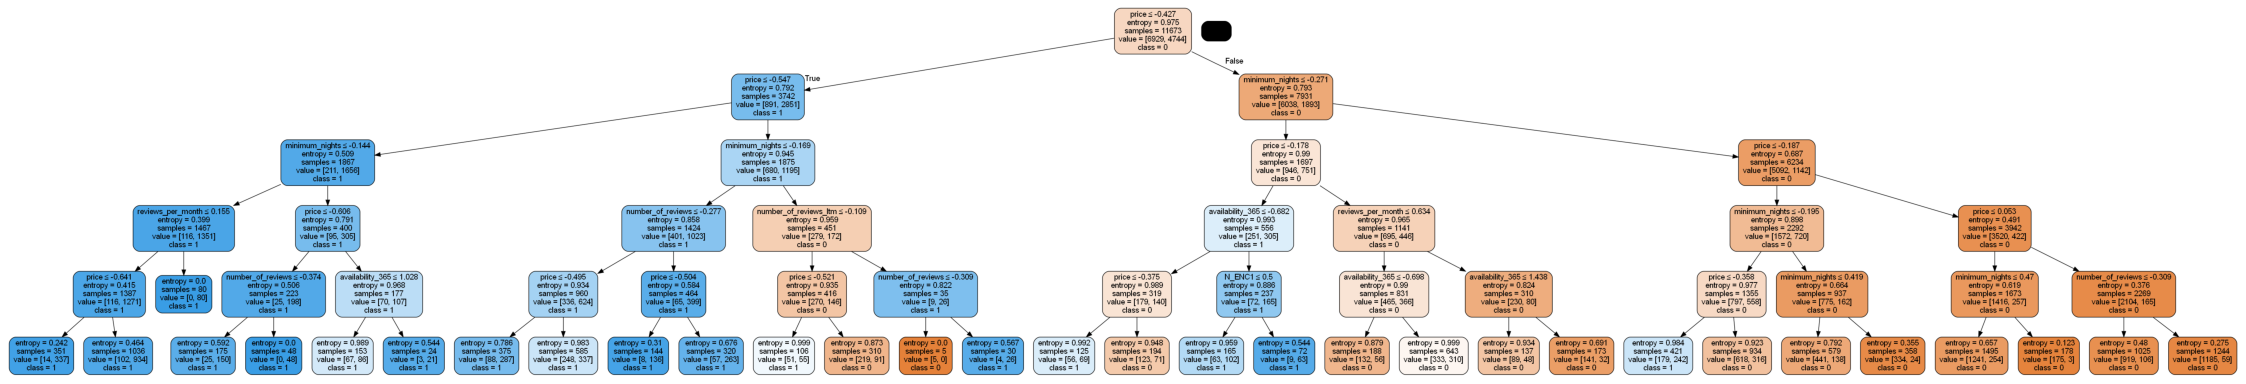

In [72]:
accuracies["DecisionTree"] = our_dec_tree_func(dummy_class, y_class, 5)

#### Here instead, we ran the algorithm with the pricipal components found by PCA


Training with maximum depth= 5
	|->End training
Testing with test set:
	|->End testing - Accuracy= 42.41%
Confusion matrix:
[[2458  501]
 [1359  685]]
Classification report
              precision    recall  f1-score   support

           0       0.64      0.83      0.73      2959
           1       0.58      0.34      0.42      2044

    accuracy                           0.63      5003
   macro avg       0.61      0.58      0.57      5003
weighted avg       0.62      0.63      0.60      5003



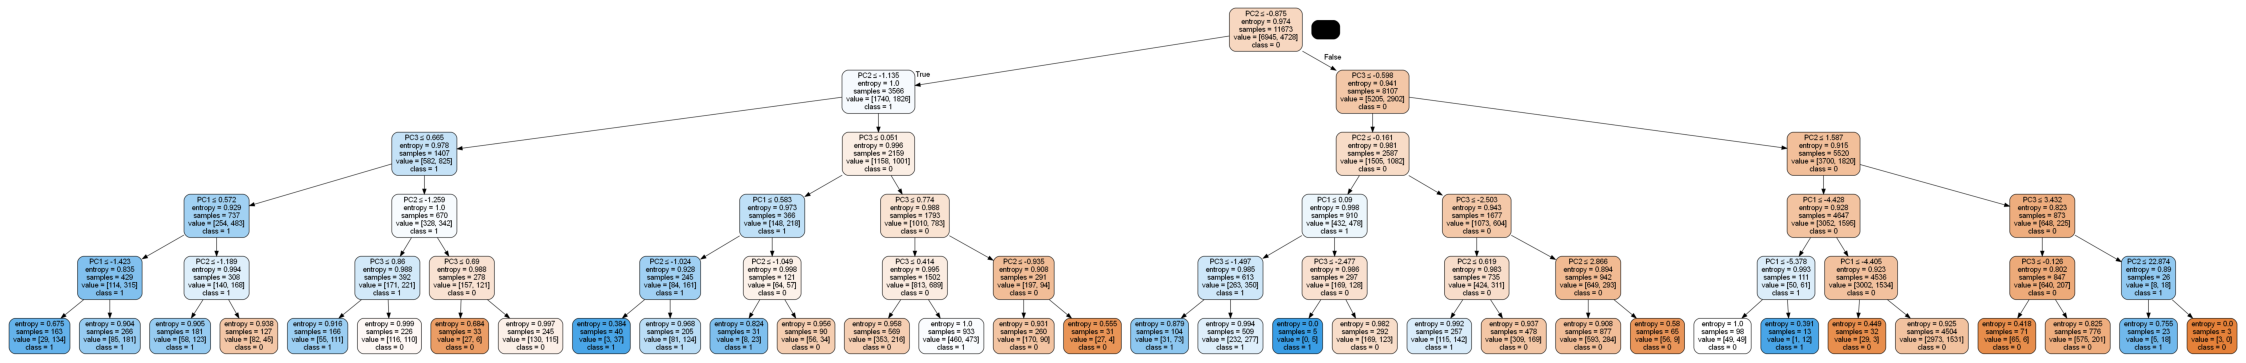

In [99]:
accuracies["DecisionTree_PCA"] = our_dec_tree_func(x_class_pca, y_class, 5)

## RANDOM FOREST :

In [84]:
# We defined our Random Forest function here.

def our_rf_func(dataset, y_class, n_estimators):
    
    x_train, x_test, y_train, y_test = train_test_split(dataset, y_class, test_size=0.3, random_state= None)
    x_train_complete = x_train 
    y_train_complete = y_train
    
    # Split in the validation and train sets, for further evaluation
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state= None)
  
  # evaluate the best number of trees needed if the parameter received is 0
    if n_estimators == 0:
        number_of_trees = [10, 20, 50, 100, 1000]
        best_accuracy = 0
        for trees in number_of_trees:
            print("\nTraining random forest classifier with n_estimators= %d" % trees)
            classifier = RandomForestClassifier(n_estimators=trees, criterion="entropy")
            classifier.fit(x_train, y_train) 
            print("\t|->End training\nTesting with validation set:")
            y_pred = classifier.predict(x_val) 
            accuracy = 100*f1_score(y_val, y_pred, average='binary')
            print("\t|->End testing - Accuracy= %.2f%%" % accuracy)
      
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            n_estimators = trees
            print("\nBest number of trees evaluated: %d" % n_estimators)
            print("---------------------------------------------------------")
            print("\nTraining random forest classifier with the best number of estimators evaluated")
    
    else: 
        print("\nTraining random forest classifier with n_estimators= %d" % n_estimators)
        classifier = RandomForestClassifier(n_estimators=n_estimators, criterion="entropy")
        classifier.fit(x_train_complete, y_train_complete) 
        print("\t|->End training\nTesting with test set:")
  
        y_pred = classifier.predict(x_test) 
        accuracy = 100*f1_score(y_test, y_pred, average='binary')
        print("\t|->End testing - Accuracy= %.2f%%" % accuracy)
        print("Confusion matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("Classification report")
        print(classification_report(y_test, y_pred))

    return accuracy

#### We ran the random forest with the entire dataset, composed by dummy variables.

In [85]:
accuracies["RandomForest"] = our_rf_func(dummy_class, y_class, 0)


Training random forest classifier with n_estimators= 10
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 70.57%

Training random forest classifier with n_estimators= 20
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 71.59%

Training random forest classifier with n_estimators= 50
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 72.48%

Training random forest classifier with n_estimators= 100
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 72.49%

Training random forest classifier with n_estimators= 1000
	|->End training
Testing with validation set:
	|->End testing - Accuracy= 73.00%

Best number of trees evaluated: 1000
---------------------------------------------------------

Training random forest classifier with the best number of estimators evaluated


#### Next, we executed the random forest classifier with the principal components found by the PCA.

In [86]:
accuracies["RandomForest_PCA"] = our_rf_func(x_class_pca, y_class, 100)


Training random forest classifier with n_estimators= 100
	|->End training
Testing with test set:
	|->End testing - Accuracy= 48.47%
Confusion matrix:
[[2261  710]
 [1155  877]]
Classification report
              precision    recall  f1-score   support

           0       0.66      0.76      0.71      2971
           1       0.55      0.43      0.48      2032

    accuracy                           0.63      5003
   macro avg       0.61      0.60      0.60      5003
weighted avg       0.62      0.63      0.62      5003



## THE K-NEAREST NEIGHBORS ALGORITHM (KNN) :

In [87]:
def our_KNN_func(dataset, y_class, k):
  # Split the dataset in train an test set
  X_train, X_test, y_train, y_test = train_test_split(dataset, y_class, test_size=0.20)
  
  if k == 0:
    min_error= math.inf
    best_k = 0
    errors = []
    print("Evaluate K in [1,40]... please wait!")
    # Calculating error for K values between 1 and 10 searching the best K value
    for i in range(1, 40):  
      #print("Evaluate KNN with K= %d" % i)
      knn = KNeighborsClassifier(n_neighbors=i)
      knn.fit(X_train, y_train)
      pred_i = knn.predict(X_test)
      error = np.mean(pred_i != y_test)
      #print("\t|->Error= %.2f" % error)
      errors.append(error)
      if error < min_error:
        min_error = error
        best_k = i

    print("Best K= %d" % best_k)
  
    # Plot the error trend
    fig, ax = plt.subplots()
    ax.grid()
    fig.figsize=(12, 6)
    ax.plot(range(1, 40), errors, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    ax.set(xlabel='K Value', ylabel='Mean Error', title='Error Rate K Value')
    plt.show()
    plt.clf()
  
  else:
    best_k = k
    
  # Performing the KNN with the best k and evaluate the results
  classifier = KNeighborsClassifier(n_neighbors=best_k)  
  
  # Training the model with the train set
  print("Train the model with K= %d" % best_k)
  classifier.fit(X_train, y_train)
  
  # Testing the model with the test set
  print("Evaluate the model:")
  y_pred = classifier.predict(X_test)
  
  # Printing result of the classification
  #print(y_pred)
  print("Confusion matrix:")
  print(confusion_matrix(y_test, y_pred))  
  print("Classification report")
  print(classification_report(y_test, y_pred))
  
  accuracy = 100*f1_score(y_test, y_pred, average='binary')
  print("Accuracy: %.2f%%" % accuracy)
  
  classifier = KNeighborsClassifier(n_neighbors=best_k) 
  title = "Learning curve for KNN with K= " + str(best_k)
  plot_learning_curve(classifier, title, X_train, y_train, cv=5)
  return accuracy

#### KNN with dataset composed by dummy variables:

Evaluate K in [1,40]... please wait!
Best K= 29


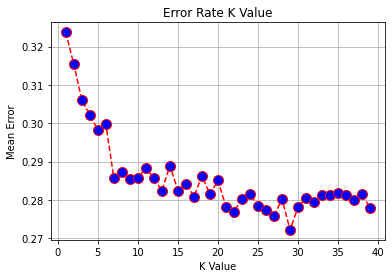

Train the model with K= 29
Evaluate the model:
Confusion matrix:
[[1647  328]
 [ 580  781]]
Classification report
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1975
           1       0.70      0.57      0.63      1361

    accuracy                           0.73      3336
   macro avg       0.72      0.70      0.71      3336
weighted avg       0.73      0.73      0.72      3336

Accuracy: 63.24%


<Figure size 432x288 with 0 Axes>

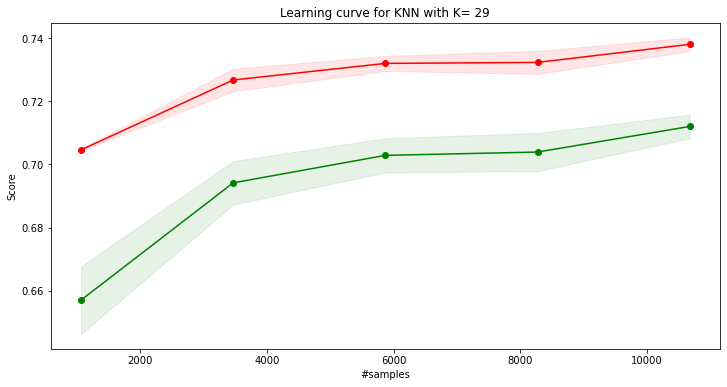

In [88]:
accuracies["KNN"] = our_KNN_func(dummy_class, y_class, 0)

#### KNN with dataset composed by the found principal components:

Evaluate K in [1,40]... please wait!
Best K= 10


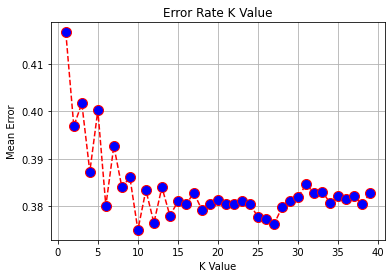

Train the model with K= 10
Evaluate the model:
Confusion matrix:
[[1618  330]
 [ 921  467]]
Classification report
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      1948
           1       0.59      0.34      0.43      1388

    accuracy                           0.62      3336
   macro avg       0.61      0.58      0.57      3336
weighted avg       0.62      0.62      0.60      3336

Accuracy: 42.75%


<Figure size 432x288 with 0 Axes>

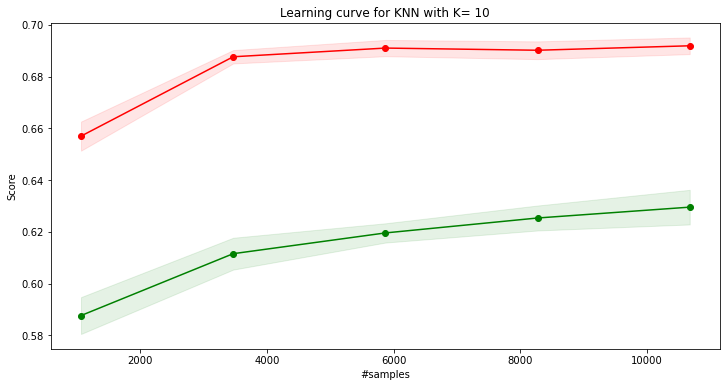

In [90]:
accuracies["KNN_PCA"] = our_KNN_func(x_class_pca, y_class, 0)

### Here we are done with classification algorithms,
##### We printed out accuracies obtained by all the classifiers used:

In [91]:
# print the accuracies obtained by the classifiers tested
for key, val in accuracies.items():
  print("%s: %.2f%%" % (key, val))

SVM_linear: 69.46%
SVM_rbf: 73.03%
DecisionTree: 71.73%
DecisionTree_PCA: 45.33%
RandomForest: 73.00%
RandomForest_PCA: 48.47%
KNN: 63.24%
KNN_PCA: 42.75%


###### As we can see, the accuracies obtained by the algorithms trained with only the principal components, 
###### are much more lower with respect to the ones with the entire dataset. 
###### This probably might be affected by the fact that there are few features, 
###### so not enough to adopt the feature reduction with the PCA. Moreover, 
###### also the accuracies with the entire dataset are not too high, always under the 90%, 
###### so with only the principal component, it only got worse.
###### Overall, the best classifier, for our dataset, is given below:

In [ ]:
max(accuracies, key=accuracies.get)

### SVM with rbf kernel had the highest accuracy which is ~75%.
### Not so bad, but not the best.